In [33]:
# TODO
# start using new ATL15 data (must merge regions or just use a single region for now)
# export gdf to csv

# Set up computing environment

In [457]:
# Code to create fig. X in Sauthoff and others, 2023
#
# Written 2023-09-06 by W. Sauthoff (sauthoff@mines.edu)

# Import packages
import datetime
import math
import matplotlib.cm as cm
import matplotlib.colors as colors  # delete when no longer needed
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import CRS, Transformer
import os
import rioxarray
from skimage import measure

# import geojson
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.patches import Rectangle
# import shapely
# from pyproj import CRS, Transformer
# import matplotlib.transforms as mtransforms

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data_dir'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Users/Wilson/Documents/data'
    # DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Define utility functions
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    Inputs
    * lon, lat in decimal degrees (lon: W is negative; lat: S is negative)
    Outputs
    * x, y polar stereographic 71 in m
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

# Change default font to Arial and increase font size
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 22})
# plt.rcParams["font.family"] = 'sans-serif' # set back to default

# Import datasets

In [ ]:
# Import CryoSat-2 data (closed-source data acquired from Ben Smith)
exec(open(SCRIPT_DIR + '/Smith_CS2.py').read())

# View dataset
CS2_dh

In [252]:
# Import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.002
if os.getenv('HOME') == '/home/jovyan':
    # TODO: Grab ATL15 data using earthaccess or icepyx
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    granule = 's3://is2view/ATLAS/ATL15/002/2019/ATL15_AA_0314_01km_002_02.nc'
    group = 'delta_h'
    ATL15_dh = rioxarray.open_rasterio(granule, group=group, masked=True)
    
# elif os.getenv('HOME') == '/Users/Wilson': 
#     file = DATA_DIR + '/altimetry/ICESat2/ATL15.002-Ant/ATL15_AA_0314_01km_002_02.nc'
#     ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)
#     # Add a new attribute
#     ATL15_dh.attrs['title'] = 'Gridded Antarctic Land Ice Height Change'

if os.getenv('HOME') == '/Users/Wilson':
    # TODO: Grab ATL15 data using earthaccess or icepyx
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A1_0318_01km_003_01.nc'
    # group = 'delta_h'
    # ATL15_dh_A1 = rioxarray.open_rasterio(granule, group=group, masked=True)
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A2_0318_01km_003_02.nc'
    # group = 'delta_h'
    # ATL15_dh_A2 = rioxarray.open_rasterio(granule, group=group, masked=True)
    granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A3_0318_01km_003_01.nc'
    group = 'delta_h'
    ATL15_dh_A3 = rioxarray.open_rasterio(granule, group=group, masked=True)
    # granule = 's3://is2view/ATLAS/ATL15/003/2019/ATL15_A4_0318_01km_003_03.nc'
    # group = 'delta_h'
#     ATL15_dh_A4 = rioxarray.open_rasterio(granule, group=group, masked=True)

/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/rioxarray/_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/rioxarray/_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity mat

In [256]:
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4461, x: 5461, time: 15)
Coordinates:
  * y                    (y) float64 2.27e+06 2.269e+06 ... -2.189e+06 -2.19e+06
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * time                 (time) float64 273.9 365.2 ... 1.461e+03 1.552e+03
    Polar_Stereographic  int64 0
Data variables:
    ice_area             (time, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/117)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [257]:
ATL15_dh_A3

<xarray.Dataset>
Dimensions:                    (y: 1391, x: 2001, band: 19)
Coordinates:
  * y                          (y) float64 0.5 1.5 2.5 ... 1.39e+03 1.39e+03
  * x                          (x) float64 0.5 1.5 2.5 ... 1.998e+03 2e+03 2e+03
  * band                       (band) int64 1 2 3 4 5 6 7 ... 14 15 16 17 18 19
    spatial_ref                int64 0
Data variables:
    delta_h_data_count         (band, y, x) float32 ...
    delta_h_delta_h            (band, y, x) float32 ...
    delta_h_delta_h_sigma      (band, y, x) float32 ...
    delta_h_ice_area           (band, y, x) float32 ...
    delta_h_misfit_rms         (band, y, x) float32 ...
    delta_h_misfit_scaled_rms  (band, y, x) float32 ...
Attributes: (12/1038)
    citation:                                                              SE...
    contributor_name:                                                      Be...
    contributor_role:                                                      In...
    Conventions:                                                           CF...
    creator_name:                                                          SE...
    date_created:                                                          20...
    ...                                                                    ...
    time_coverage_end:                                                     20...
    time_coverage_start:                                                   20...
    time_type:                                                             CC...
    title:                                                                 SE...
    vertical_datum:                                                        WGS84
    _NCProperties:                                                         ve...

In [ ]:
# Import subglacial lake outline inventories
exec(open(SCRIPT_DIR + '/Smith2009_outlines.py').read())
exec(open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py').read())
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

In [ ]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [ ]:
# Clip CS2_dh to grounding line (first set crs)
# CS2_dh.rio.write_crs(3031, inplace=True)
# CS2_dh_clipped = ATCS2_dhL15_dh.rio.clip(moa_2014_groundingline.geometry.values, moa_2014_groundingline.crs, drop=False)

In [ ]:
# clip ATL15_dh to grounding line (first set crs)
# ATL15_dh.rio.write_crs(3031, inplace=True)
# ATL15_dh_clipped = ATL15_dh.rio.clip(moa_2014_groundingline.geometry.values, moa_2014_groundingline.crs, drop=False)

# Plots

/var/folders/g0/02x3pch54zd3dy5hy6q76dhw0000gn/T/ipykernel_4623/2216681461.py:206: RuntimeWarning: Mean of empty slice
  avg_lk_dhdt = np.nanmean(dhdt_clip)


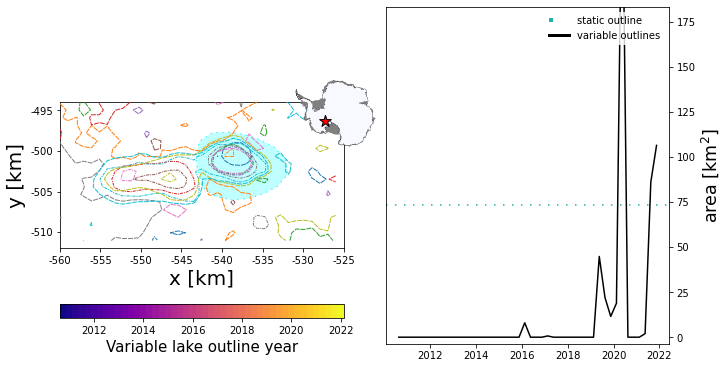

In [ ]:
# Editing to stitch CS2 and IS2 data together

thres=0.5
dataset1=CS2_dh
dataset2=ATL15_dh

lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
lake_SF18 = SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == 'Whillans_7']
S09_color = 'lightseagreen'
SF18_color = 'teal'

# Manually set because of new lake lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

# Subset dataset and MOA imagery to region of interest using data masks
mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
ds_sub1 = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
ds_sub2 = dataset2.where(mask_x & mask_y, drop=True)
# mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
# mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
# moa_highres_da_sub = moa_highres_da.where(mask_x & mask_y, drop=True)

# get dates
dates = []
for idx in range(len(dataset1.delta_h[:-12])):
    dhdt = dataset1.delta_h[idx+1,:,:]-dataset1.delta_h[idx,:,:]
    # calculate mid-cycle dates for plotting
    newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
    newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
for idx in range(len(dataset2.delta_h)-1): 
    dhdt = dataset2.delta_h[idx+1,:,:]-dataset2.delta_h[idx,:,:]
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
        
# Pick colormap and make continuous cmap discrete
cmap = cm.get_cmap('plasma', len(dates)-1)
# Norm to time variable
norm = plt.Normalize(ds_sub1.time.values[0], ds_sub2.time.values[-1])

# Plot figure
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(10,5))#, gridspec_kw={'width_ratios': [2, 1, 1], 'height_ratios': [1]})

# Overlay published active lake outlines for visual comparison
Smith2009_outlines.boundary.plot(ax=axs[0], facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=axs[0], edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

# Set axes limits
axs[0].set(#xticks=[], yticks=[], 
           xlim=(x_min, x_max), ylim=(y_min, y_max))

# Change polar stereographic m to km for cleaner-looking axes
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].yaxis.set_major_formatter(ticks_y)  

# Label axes
axs[0].set_xlabel('x [km]', size=20)
axs[0].set_ylabel('y [km]', size=20)

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=4)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=3)

# Plot inset map to show location 
axIns = axs[0].inset_axes([0.72, 0.68, 0.5, 0.5]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1) 
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=150, zorder=3)
axIns.axis('off')

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date) for date in dates[0:]]))
cax = inset_axes(axs[0],
                    width="100%",  
                    height="10%",
                    loc='lower center',
                    borderpad=-7
                   )
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Variable lake outline year', size=15)

# Create empty lists to store calculated data
lkavgdhdt_S09 = []
lkavgdhdt_SF18 = []
lkavgdhdt_var = []
areas_var = []
vols_S09 = []
vols_SF18 = []
vols_var = []

for idx in range(len(dates)-1):
    # Stitch together CryoSat-2 and ICESat-2 time series
    if idx < 35:
        dhdt = ds_sub1.delta_h[idx+1,:,:]-ds_sub1.delta_h[idx,:,:]
    elif idx > 34:
        dhdt = ds_sub2.delta_h[(idx-40)+1,:,:]-ds_sub2.delta_h[(idx-40),:,:]

    # Clip dh/dt to published static outlines
    dhdt.rio.write_crs(3031, inplace=True)
    dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
    dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)

    # Calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
    avg_lk_dhdt_S09 = np.nanmean(dhdt_clip_S09)
    avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
    lkavgdhdt_S09 += [avg_lk_dhdt_S09]
    lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
    vol_S09 = avg_lk_dhdt_S09*sum(lake_S09.area) # FIXME: change to geodesic area
    vol_SF18 = avg_lk_dhdt_SF18*sum(lake_SF18.area)
    vols_S09 += [vol_S09]
    vols_SF18 += [vol_SF18]

    # Create contours of ice surface elevation height changes to delineate lake outlines
    contours_fill = []
    contours_drain = []
    polys = []
    contour = measure.find_contours(dhdt.values, thres)
    if len(contour) > 0: 
        contours_fill += [contour]
    contour = measure.find_contours(dhdt.values, -thres)
    if len(contour) > 0: 
        contours_drain += [contour]

    # Create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/dhdt.shape[1]
    y_conv = (y_max-y_min)/dhdt.shape[0]

    # Plot and make polygons from variable outlines
    for i in range(len(contours_fill)): 
        for j in range(len(contours_fill[i])):
            if len(contours_fill[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(dates[idx])), 
                    linestyle=(0, (3, 1, 1, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv)))
                polys += [poly]
    for i in range(len(contours_drain)): 
        for j in range(len(contours_drain[i])):
            if len(contours_drain[i][j][:, 1]) > 2: 
                axs[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                    # color=cmap(norm(dates[idx])), 
                    linestyle=(0, (5, 1)), linewidth=1, zorder=3)
                poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                polys += [poly]

    # Start with baseline variable outline area of zero
    area_var = 0
    # If polygons are present at time step, 
    if len(polys) > 0: 
        # Clip data to polygons 
        dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
        # Then calculate on-lake averages of dh/dt
        avg_lk_dhdt = np.nanmean(dhdt_clip)
        # Occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
        # eplace with zeros
        if math.isnan(avg_lk_dhdt): 
            avg_lk_dhdt = 0
            lkavgdhdt_var += [avg_lk_dhdt]
        else:
            lkavgdhdt_var += [avg_lk_dhdt]                
        # and dv/dt
        for i in range(len(polys)):
            area_var = area_var + polys[i].area # TODO: CHANGE TO GEODESIC AREA
        # Store areas in list 
        areas_var += [area_var]
        # Calculate and store volumes in list
        vol_var = avg_lk_dhdt*area_var
        vols_var += [vol_var]
    else: 
        # Store areas in list 
        areas_var += [area_var]
        # Set lake dhdt to zero because no variable outline polygons
        avg_lk_dhdt = 0
        # Store dhdt's in list 
        lkavgdhdt_var += [avg_lk_dhdt]
        # Calculate variable volumes
        vol_var = avg_lk_dhdt*area_var
        # Store variable volumes in list
        vols_var += [vol_var]

# Calculate bias
# S09_var_dh_bias = [a_i - b_i for a_i, b_i in zip(lkavgdhdt_var, lkavgdhdt_S09)]
# S09_var_vol_bias = [a_i - b_i for a_i, b_i in zip(np.cumsum(vols_var), np.cumsum(vols_S09))]

# Plot 1 - plot area change time series
axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 5)))
axs[1].plot(dates[:idx+1], np.divide(areas_var[:idx+1], 1e6), color='k', linestyle='solid')
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)
min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                min(np.divide(np.cumsum(areas_var),1e6)))
max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                np.divide(sum(lake_SF18.area), 1e6), 
                max(np.divide(np.cumsum(areas_var),1e6)))
axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)))
axs[1].set_ylabel('area [km$^2$]', size=17.5, labelpad=4)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
variable_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle='solid', linewidth=3)
legend2 = axs[1].legend([Smith2009,
    #SiegfriedFricker2018,
    variable_outlines],
                ['static outline',
    #'Siegfried & Fricker, 2018 static outline',
    # '±{} m variable outlines'.format(thres)], 
    'variable outlines'],
    loc='upper right')
legend2.get_frame().set_linewidth(0.0)
axs[1].patch.set_alpha(1)

# # Plot 2 - height change time series
# axs[2].plot(dates[:-1], lkavgdhdt_S09, color=S09_color, linestyle=(0, (1, 5)))
# axs[2].plot(dates[:-1], lkavgdhdt_var, color='k', linestyle='solid')
# axs[2].plot(dates[:-1], S09_var_dh_bias, color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[2].xaxis.set_major_locator(locator)
# axs[2].xaxis.set_major_formatter(formatter)
# axs[2].set_xlabel('year', size=17.5)
# axs[2].set_ylabel('height change [m]', size=17.5, labelpad=5)
# axs[2].yaxis.tick_right()
# axs[2].yaxis.set_label_position("right")
# bias = plt.Line2D((0, 1), (0, 0), color='r', linestyle='solid', linewidth=3)
# legend = axs[2].legend([#Smith2009,
#     #SiegfriedFricker2018,
#     bias],
#                 [#'static outline',
#     #'Siegfried & Fricker, 2018 static outline',
#     # '±{} m variable outlines'.format(thres)], 
#     'bias'],
#     loc='lower right')
# legend.get_frame().set_linewidth(0.0)
# axs[2].patch.set_alpha(1)

# # Plot 3 - volume change time series
# axs[3].plot(dates[:-1], np.divide(np.cumsum(vols_S09), 1e+9), color=S09_color, linestyle=(0, (1, 5)))
# axs[3].plot(dates[:-1], np.divide(np.cumsum(vols_var), 1e+9), color='k', linestyle='solid')
# axs[3].plot(dates[:-1], np.divide(S09_var_vol_bias, 1e+9), color='r', linestyle='solid')
# locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
# formatter = mdates.ConciseDateFormatter(locator)
# axs[3].xaxis.set_major_locator(locator)
# axs[3].xaxis.set_major_formatter(formatter)
# min_vol = min(np.divide(min(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(min(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(min(np.cumsum(vols_var)), 1e+9))
# max_vol = max(np.divide(max(np.cumsum(vols_S09)), 1e+9), 
#             #   np.divide(max(np.cumsum(vols_SF18)), 1e+9), 
#                 np.divide(max(np.cumsum(vols_var)), 1e+9))

# axs[3].set(xlim=(dates[0], dates[-1]), 
#             ylim=((min_vol - (max_vol - min_vol)*0.05),
#                     (max_vol + (max_vol - min_vol)*0.05)))
# axs[3].set_xlabel('year', size=17.5)
# axs[3].set_ylabel('vol. change [km$^3$]', size=17.5, labelpad=0)
# axs[3].yaxis.tick_right()
# axs[3].yaxis.set_label_position("right")
# axs[3].patch.set_alpha(1)

# Save and close figure
# plt.savefig('/Users/Wilson/Documents/0-code/output/output_S09SF18varoutlines-visual-imagery/S09SF18varoutlines_agg_moa_plot/regions/S09SF18varoutlines_agg_moa_plot-{}-{}.png'.format(region_name,dataset.Title), dpi=300, bbox_inches = "tight") # change to name after region name given as func input?
# plt.close()
plt.show()

In [ ]:
# TODO
# fix y axis bounds on da/dt plot
# colormap of outlines not working when using cmap (vmin exceeds vmax)

In [262]:
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4461, x: 5461, time: 15)
Coordinates:
  * y                    (y) float64 2.27e+06 2.269e+06 ... -2.189e+06 -2.19e+06
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * time                 (time) float64 273.9 365.2 ... 1.461e+03 1.552e+03
    Polar_Stereographic  int64 0
Data variables:
    ice_area             (time, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/117)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [321]:
# ensure dates acquisition working
dates = []
dataset1 = CS2_dh
dataset2 = ATL15_dh
for idx in range(len(dataset1.delta_h[:-12])):
    dhdt = dataset1.delta_h[idx+1,:,:]-dataset1.delta_h[idx,:,:]
    # calculate mid-cycle dates for plotting
    newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
    newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
for idx in range(len(dataset2.delta_h)-1): 
    dhdt = dataset2.delta_h[idx+1,:,:]-dataset2.delta_h[idx,:,:]
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
dates

[datetime.datetime(2010, 8, 17, 6, 45),
 datetime.datetime(2010, 11, 16, 11, 15),
 datetime.datetime(2011, 2, 15, 15, 45),
 datetime.datetime(2011, 5, 17, 23, 15),
 datetime.datetime(2011, 8, 17, 6, 45),
 datetime.datetime(2011, 11, 16, 11, 15),
 datetime.datetime(2012, 2, 15, 15, 45),
 datetime.datetime(2012, 5, 16, 23, 15),
 datetime.datetime(2012, 8, 16, 6, 45),
 datetime.datetime(2012, 11, 15, 23, 15),
 datetime.datetime(2013, 2, 15, 15, 45),
 datetime.datetime(2013, 5, 17, 23, 15),
 datetime.datetime(2013, 8, 17, 6, 45),
 datetime.datetime(2013, 11, 16, 11, 15),
 datetime.datetime(2014, 2, 15, 15, 45),
 datetime.datetime(2014, 5, 17, 23, 15),
 datetime.datetime(2014, 8, 17, 6, 45),
 datetime.datetime(2014, 11, 16, 11, 15),
 datetime.datetime(2015, 2, 15, 15, 45),
 datetime.datetime(2015, 5, 17, 23, 15),
 datetime.datetime(2015, 8, 17, 6, 45),
 datetime.datetime(2015, 11, 16, 11, 15),
 datetime.datetime(2016, 2, 15, 15, 45),
 datetime.datetime(2016, 5, 16, 23, 15),
 datetime.dateti

In [267]:
# ensure dates acquisition working
dates = []
dataset1 = CS2_dh
dataset2 = ATL15_dh_A3
for idx in range(len(dataset1.delta_h[:-12])):
    # calculate mid-cycle dates for plotting
    newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
    newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
for idx in range(len(dataset2.delta_h_delta_h)-1): 
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=182.625 + 91.3125 * float(dataset2.band.values[idx]))
    newdate1 = date_time_obj + datetime.timedelta(days=182.625 + 91.3125 * float(dataset2.band.values[idx+1]))
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    dates += [midcycdate]
dates

[datetime.datetime(2010, 8, 17, 6, 45),
 datetime.datetime(2010, 11, 16, 11, 15),
 datetime.datetime(2011, 2, 15, 15, 45),
 datetime.datetime(2011, 5, 17, 23, 15),
 datetime.datetime(2011, 8, 17, 6, 45),
 datetime.datetime(2011, 11, 16, 11, 15),
 datetime.datetime(2012, 2, 15, 15, 45),
 datetime.datetime(2012, 5, 16, 23, 15),
 datetime.datetime(2012, 8, 16, 6, 45),
 datetime.datetime(2012, 11, 15, 23, 15),
 datetime.datetime(2013, 2, 15, 15, 45),
 datetime.datetime(2013, 5, 17, 23, 15),
 datetime.datetime(2013, 8, 17, 6, 45),
 datetime.datetime(2013, 11, 16, 11, 15),
 datetime.datetime(2014, 2, 15, 15, 45),
 datetime.datetime(2014, 5, 17, 23, 15),
 datetime.datetime(2014, 8, 17, 6, 45),
 datetime.datetime(2014, 11, 16, 11, 15),
 datetime.datetime(2015, 2, 15, 15, 45),
 datetime.datetime(2015, 5, 17, 23, 15),
 datetime.datetime(2015, 8, 17, 6, 45),
 datetime.datetime(2015, 11, 16, 11, 15),
 datetime.datetime(2016, 2, 15, 15, 45),
 datetime.datetime(2016, 5, 16, 23, 15),
 datetime.dateti

In [268]:
# exploring why y and x_conv are causing issues
def image_contouring_func(x_min, x_max, y_min, y_max, buffer, threshold, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot time-variable outlines as polygons.
    Inputs: 
        x_min, x_max, y_min, y_max: polar stereographic coords
        threshold: vertical distance in meters to delineate ice surface deformation contour; 
            input as python list of singular or multiple threshold values to explore which is appropriate 
        dataset: dataset to be analyzed (here ATL15_dh as example)
    Outputs: 
        Sequence of planview dh/dt visuals of ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
        List of polygons created at each step (would need to modify to collect all polygons 
        at all time steps)
    '''
    # if Sauthoff2023_outlines['name'].str.contains(region_or_lake).any():
    #     # Isolate individual lake using gpd buffer
    #     lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
    #     lake_buffer = lake_gpd.buffer(buffer)
    #     # Define lake bounding box
    #     x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    #     y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    #     # Subset CryoSat-2 SARIn data set to region of interest
    #     mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    #     mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    #     ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    #     # Subset ATL15 data set to region of interest
    #     mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    #     mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    #     ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)

    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)

    # create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.001': 
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=182.625 + 91.3125 * float(dataset2.band.values[idx]))
            newdate1 = date_time_obj + datetime.timedelta(days=182.625 + 91.3125 * float(dataset2.band.values[idx+1]))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # Calculate cycle-to-cycle dh/dt at each cycle of the spliced data sets
    for idx in range(len(dates)-1): 
        if idx < 35:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            midcycdate = dates[idx]
            # create mapping conversion factor to map array location of created contours to polar stereographic x,y
            # x_conv = (x_max-x_min)/ds1_clipped.delta_h[0,:,:].shape[1]
            # y_conv = (y_max-y_min)/ds1_clipped.delta_h[0,:,:].shape[0]
        elif idx > 34:
            dhdt = ds2_clipped.delta_h[(idx-40)+1,:,:]-ds2_clipped.delta_h[idx-40,:,:]
            midcycdate = dates[idx]
            # x_conv = (x_max-x_min)/ds2_clipped.delta_h[0,:,:].shape[1]
            # y_conv = (y_max-y_min)/ds2_clipped.delta_h[0,:,:].shape[0]
        
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]

        # create fig, ax
        fig, ax = plt.subplots(figsize=(8,8))

        # plot figure
        img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
            origin='upper', cmap='coolwarm_r', norm=colors.CenteredNorm())
        
        # create empty lists to store contours 
        contours_pos = []
        contours_neg = []

        # for loop to create contours of each threshold given 
        contour = measure.find_contours(dhdt.values, threshold)
        if len(contour) > 0: 
            contours_pos += [contour]
        contour = measure.find_contours(dhdt.values, -threshold)
        if len(contour) > 0: 
            contours_neg += [contour]

        # plot contours and make into polygons
        for i in range(len(contours_pos)): 
            for j in range(len(contours_pos[i])):
                x = x_min+contours_pos[i][j][:,1]*x_conv
                y = y_max-contours_pos[i][j][:,0]*y_conv
                ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
                # make polygons from variable outlines and store to list
                if len(contours_pos[i][j][:,1]) > 2: 
                    poly = Polygon(list(zip(x, y))) 
                    polys += [poly]
                    # calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        for i in range(len(contours_neg)): 
            for j in range(len(contours_neg[i])):
                x = x_min+contours_neg[i][j][:,1]*x_conv
                y = y_max-contours_neg[i][j][:,0]*y_conv
                ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)
                # make polygons from variable outlines
                if len(contours_neg[i][j][:,1]) > 2: 
                    poly = Polygon(list(zip(x, y)))
                    polys += [poly]
                    # calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        # change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  

        # label axes
        ax.set_xlabel('x [m]', size=15)
        ax.set_ylabel('y [m]', size=15)
        ax.set_title('dh [m] on {}'.format(midcycdate.date()), size=15)

        # Plot inset map to show location 
        axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
        axIns.add_artist(rect) 
        axIns.axis('off')

        # add color bar 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)
        # add legend
        ax.legend([uplift, subsidence],
            [('+ '+str(threshold)+' m uplift (filling) variable outline'), ('– '+str(threshold)+' m subsidence (draining) variable outline')], 
            loc='upper left')
        
    # store polygons in geopandas geodataframe for analysis
    d = {'geometry': polys, 'area (km^2)': areas, 'perim (km)': perims, 'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())
    
    return gdf

In [271]:
dataset2 = ATL15_dh_A3

# manually set because of lake-adjacent lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)
ds2_clipped

ValueError: zero-size array to reduction operation minimum which has no identity

In [270]:
# region_or_lake = 'Whillans_7'
# buffer = 20000

# # Isolate individual lake using gpd buffer
# lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
# lake_buffer = lake_gpd.buffer(buffer)
# # Define lake bounding box
# x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
# y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

# manually set because of lake-adjacent lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

gdf = image_contouring_func(x_min, x_max, y_min, y_max, 15000, 0.5, CS2_dh, ATL15_dh_A3)

ValueError: zero-size array to reduction operation minimum which has no identity

In [287]:
def S09SF18S23_outline_timeseries_gdf(region_or_lake, buffer, threshold, dataset1, dataset2):
    '''
    Create time series of variable outlines compared to known lakes or across a larger region to additionally find lake candidates. Uses geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 (SF18) inventory if lake is input.
    Creates time-evolving outlines using skimage contour to create variable outlines. 
    Inputs: 
        region_or_lake: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from lake outline used to create bounding box that is displayed around lake of interest
        threshold: vertical distance in meters to delineate ice surface deformation contour
        dataset1: dataset to be analyzed (CS2_dh or CS2SARIn_elev)
        dataset2: dataset to be analyzed (ATL15_dh)
    Outputs: 
        gdf: geodataframe of variable outlines
    '''
    if Sauthoff2023_outlines['name'].str.contains(region_or_lake).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
        lake_buffer = lake_gpd.buffer(buffer)
        # Define lake bounding box
        x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
        y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
        # Subset CryoSat-2 SARIn data set to region of interest
        mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
        mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
        ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
        # Subset ATL15 data set to region of interest
        mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
        mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
        ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)

    # elif IMBIE_basins['NAME'].str.contains(region_or_lake).any():
    #     # Isolate individual basin as geodf
    #     basin = IMBIE_basins[IMBIE_basins['NAME'] == region_or_lake]
    #     # Clip dataset to IMBIE basin of interest
    #     ds_clipped = dataset.rio.clip(basin.geometry.values, basin.crs)
    #     # Define region bounding box
    #     x_min = basin.geometry.bounds.minx.values[0]; x_max = basin.geometry.bounds.maxx.values[0]
    #     y_min = basin.geometry.bounds.miny.values[0]; y_max = basin.geometry.bounds.maxy.values[0]

    # create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # create mapping conversion factor to map array location of created contours to polar stereographic x,y
    # x_conv = (x_max-x_min)/ds1_clipped.delta_h[0,:,:].shape[1]
    # y_conv = (y_max-y_min)/ds1_clipped.delta_h[0,:,:].shape[0]
    # Test if conversion factor the same if using ATL15 data
    # x_conv = (x_max-x_min)/ds2_clipped.delta_h[0,:,:].shape[1]
    # y_conv = (y_max-y_min)/ds2_clipped.delta_h[0,:,:].shape[0]

    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # Calculate cycle-to-cycle dh/dt at each cycle of the spliced data sets
    for idx in range(len(dates)-1): 
        if idx < 35:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            midcycdate = dates[idx]
            # create mapping conversion factor to map array location of created contours to polar stereographic x,y
            # x_conv = (x_max-x_min)/ds1_clipped.delta_h[0,:,:].shape[1]
            # y_conv = (y_max-y_min)/ds1_clipped.delta_h[0,:,:].shape[0]
        elif idx > 34:
            dhdt = ds2_clipped.delta_h[(idx-40)+1,:,:]-ds2_clipped.delta_h[idx-40,:,:]
            midcycdate = dates[idx]
            # x_conv = (x_max-x_min)/ds2_clipped.delta_h[0,:,:].shape[1]
            # y_conv = (y_max-y_min)/ds2_clipped.delta_h[0,:,:].shape[0]    
       
        # Create empty lists to store contours 
        contours_pos = []
        contours_neg = []

        # Create contours of ice surface elevation height changes to delineate variable lake outlines
        contour = measure.find_contours(dhdt.values, threshold)
        if len(contour) > 0: 
            contours_pos += [contour]
        contour = measure.find_contours(dhdt.values, -threshold)
        if len(contour) > 0: 
            contours_neg += [contour]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]

        # Make contours and make into polygons
        for i in range(len(contours_pos)): 
            for j in range(len(contours_pos[i])):
                x = x_min+contours_pos[i][j][:,1]*x_conv
                y = y_max-contours_pos[i][j][:,0]*y_conv

                # Make polygons from variable outlines and store to list
                if len(contours_pos[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x, y))) 
                    polys += [poly]

                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6  # km^2
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3  # km
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]

        for i in range(len(contours_neg)): 
            for j in range(len(contours_neg[i])):
                x = x_min+contours_neg[i][j][:,1]*x_conv
                y = y_max-contours_neg[i][j][:,0]*y_conv

                # Make polygons from variable outlines
                if len(contours_neg[i][j][:, 1]) > 2: 
                    poly = Polygon(list(zip(x, y)))
                    polys += [poly]

                    # Calc polygon area and perimeter and store to lists
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                    poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                    areas += [poly_area]
                    perims += [poly_perim]
                    datetimes += [midcycdate]
    
    # Store polygons in geopandas geodataframe for analysis
    d = {'geometry': polys, 'area (km^2)': areas, 'perim (km)': perims, 'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())
    
    return gdf

In [424]:
gdf = S09SF18S23_outline_timeseries_gdf('Whillans_7', 20000, 0.5, CS2_dh, ATL15_dh)
gdf

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-536901.512 -501370.300, -536544.048...",8.849766,10.812016,2016-02-15 15:45:00,POINT (-538068.418 -500133.369),2016-02-15
1,"POLYGON ((-538515.859 -500424.141, -539501.764...",0.777978,3.752695,2017-02-15 15:45:00,POINT (-538912.564 -500048.496),2017-02-15
2,"POLYGON ((-537529.954 -502626.663, -538515.859...",14.456040,13.952594,2019-05-18 05:15:00,POINT (-538658.385 -500931.754),2019-05-18
3,"POLYGON ((-543445.385 -504532.395, -544431.290...",35.202609,25.637187,2019-05-18 05:15:00,POINT (-548330.245 -503171.618),2019-05-18
4,"POLYGON ((-537529.954 -502798.124, -538515.859...",15.041821,14.406876,2019-08-17 12:45:00,POINT (-538632.951 -501073.966),2019-08-17
...,...,...,...,...,...,...
113,"POLYGON ((-540487.669 -500462.624, -540507.708...",0.001680,0.207462,2020-11-16 02:15:00,POINT (-540488.721 -500407.327),2020-11-16
114,"POLYGON ((-551332.626 -503562.579, -552318.532...",2.189495,5.633261,2021-05-17 17:15:00,POINT (-551643.030 -502852.681),2021-05-17
115,"POLYGON ((-534572.238 -509718.836, -535558.143...",2.661473,6.056334,2021-08-17 00:45:00,POINT (-535112.884 -508895.324),2021-08-17
116,"POLYGON ((-543373.857 -505317.632, -542961.736...",92.846020,51.197944,2021-08-17 00:45:00,POINT (-543358.477 -502131.943),2021-08-17


In [ ]:
dates

[datetime.datetime(2010, 8, 17, 6, 45),
 datetime.datetime(2010, 11, 16, 11, 15),
 datetime.datetime(2011, 2, 15, 15, 45),
 datetime.datetime(2011, 5, 17, 23, 15),
 datetime.datetime(2011, 8, 17, 6, 45),
 datetime.datetime(2011, 11, 16, 11, 15),
 datetime.datetime(2012, 2, 15, 15, 45),
 datetime.datetime(2012, 5, 16, 23, 15),
 datetime.datetime(2012, 8, 16, 6, 45),
 datetime.datetime(2012, 11, 15, 23, 15),
 datetime.datetime(2013, 2, 15, 15, 45),
 datetime.datetime(2013, 5, 17, 23, 15),
 datetime.datetime(2013, 8, 17, 6, 45),
 datetime.datetime(2013, 11, 16, 11, 15),
 datetime.datetime(2014, 2, 15, 15, 45),
 datetime.datetime(2014, 5, 17, 23, 15),
 datetime.datetime(2014, 8, 17, 6, 45),
 datetime.datetime(2014, 11, 16, 11, 15),
 datetime.datetime(2015, 2, 15, 15, 45),
 datetime.datetime(2015, 5, 17, 23, 15),
 datetime.datetime(2015, 8, 17, 6, 45),
 datetime.datetime(2015, 11, 16, 11, 15),
 datetime.datetime(2016, 2, 15, 15, 45),
 datetime.datetime(2016, 5, 16, 23, 15),
 datetime.dateti

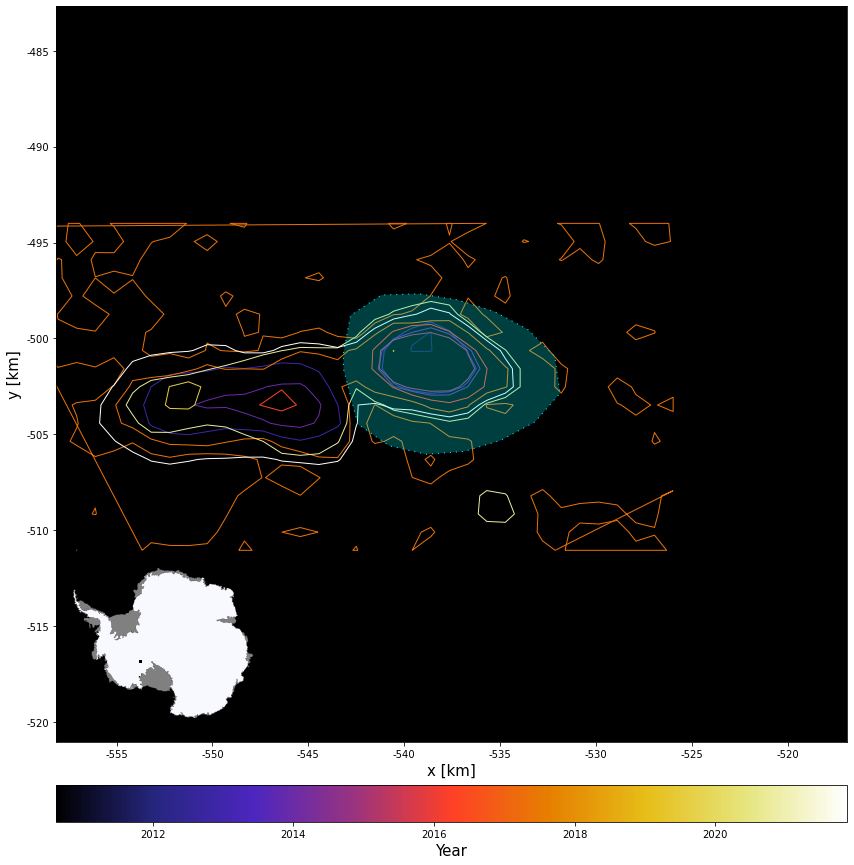

In [ ]:
# Set up dataset
dataset1 = CS2_dh
dataset2 = ATL15_dh
dates = []
# Find mid-cycle dates of combined CS2 and IS2 data
dates = []
for idx in range(len(dataset1.delta_h[:-12])):
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
for idx in range(len(dataset2.delta_h)-1): 
    if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]

region_or_lake = 'Whillans_7'
buffer = 15000

# Isolate individual lake using gpd buffer
lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
lake_buffer = lake_gpd.buffer(buffer)
# Define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

# create fig, ax
fig, ax = plt.subplots(figsize=(15,15))

cmap = plt.get_cmap('CMRmap')
norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])

m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Year', size=15)

# Add black background to see all outlines
rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
ax.add_artist(rect) 


# gdf[gdf['date'] == datetime.date(2020, 5, 17)].plot(ax=ax, 
#     column='date',
#     facecolor='none',
#     cmap=cmap,
#     legend=False
#     )

# gdf[gdf['date'] == datetime.date(2021, 8, 17)].plot(ax=ax, 
#     column='date',
#     facecolor='none',
#     cmap=cmap,
#     legend=False
#     )

# gdf[gdf['date'] == datetime.date(2021, 11, 16)].plot(ax=ax, 
#     column='date',
#     facecolor='none',
#     cmap=cmap,
#     legend=False
#     )

gdf.plot(ax=ax, 
    column='date',
    facecolor='none',
    cmap=cmap,
    legend=False
    )

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_aspect('equal')

# Label axes and set limits
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

# Plot inset map to show location 
axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
axIns.add_artist(rect) 
axIns.axis('off')

plt.show()

In [157]:
overlapping = []
non_overlapping = []
for n, p in enumerate(list(gdf.geometry), 0):
    if any(p.overlaps(g) for g in list(gdf.geometry)):
        # Store the index from the original dataframe
        overlapping.append(n)
    if not any(p.overlaps(g) for g in list(gdf.geometry)):
        non_overlapping.append(n)

# Create a new dataframes and reset their indexes
gdf_overlapping = gdf.iloc[overlapping]  
gdf_overlapping.reset_index(drop=True, inplace=True)
gdf_non_overlapping = gdf.iloc[non_overlapping]
gdf_non_overlapping.reset_index(drop=True, inplace=True)

In [160]:
# Remove polygons with area above the 95th percentile and below the 5th percentile
gdf2 = gdf[(gdf['area (km^2)'] < gdf['area (km^2)'].quantile(0.99)) &
           (gdf['area (km^2)'] > gdf['area (km^2)'].quantile(0.01))]

In [161]:
overlapping = []
non_overlapping = []
for n, p in enumerate(list(gdf2.geometry), 0):  # Used Pythonic zero-based indexing
    if any(p.overlaps(g) for g in list(gdf2.geometry)):
        # Store the index from the original dataframe
        overlapping.append(n)
    if not any(p.overlaps(g) for g in list(gdf2.geometry)):
        non_overlapping.append(n)

# Create a new dataframes and reset their indexes
gdf2_overlapping = gdf2.iloc[overlapping]  
gdf2_overlapping.reset_index(drop=True, inplace=True)
gdf2_non_overlapping = gdf2.iloc[non_overlapping]
gdf2_non_overlapping.reset_index(drop=True, inplace=True)

In [52]:
def plot_whillans(gdf):
    # Set up dataset
    dataset1 = CS2_dh
    dataset2 = ATL15_dh
    dates = []
    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    region_or_lake = 'Whillans_7'
    buffer = 15000

    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
    lake_buffer = lake_gpd.buffer(buffer)
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

    # manually set because of lake-adjacent lobe
    x_min = -560e3; x_max = -525e3
    y_min = -512e3; y_max = -494e3

    # create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    cmap = plt.get_cmap('CMRmap')
    # norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Year', size=15)

    # Add black background to see all outlines
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    gdf.plot(ax=ax, 
        column='date',
        facecolor='none',
        cmap=cmap,
        legend=False
        )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    plt.show()

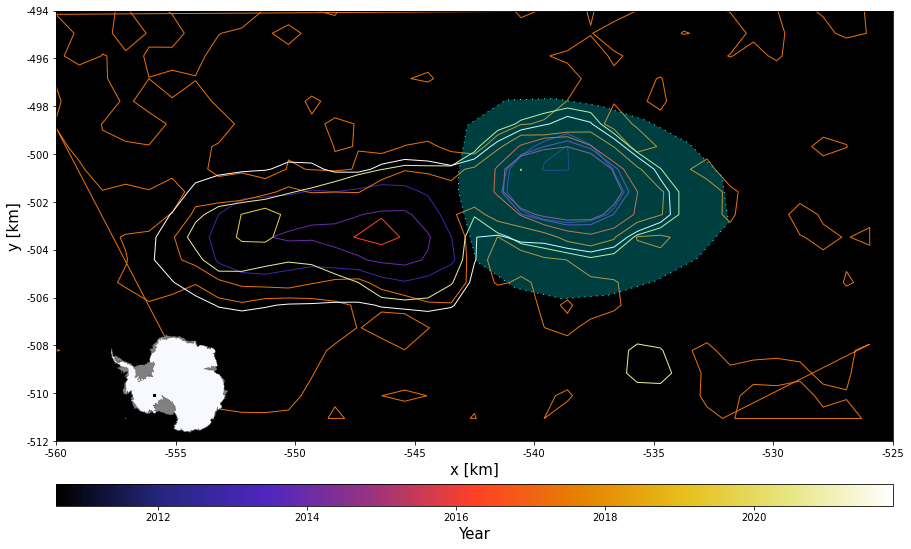

In [162]:
plot_whillans(gdf)

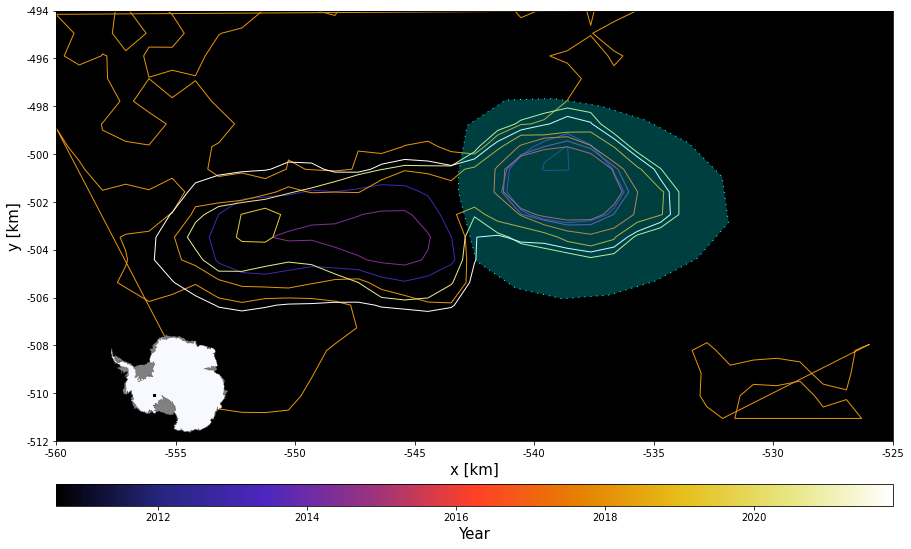

In [163]:
plot_whillans(gdf_overlapping)

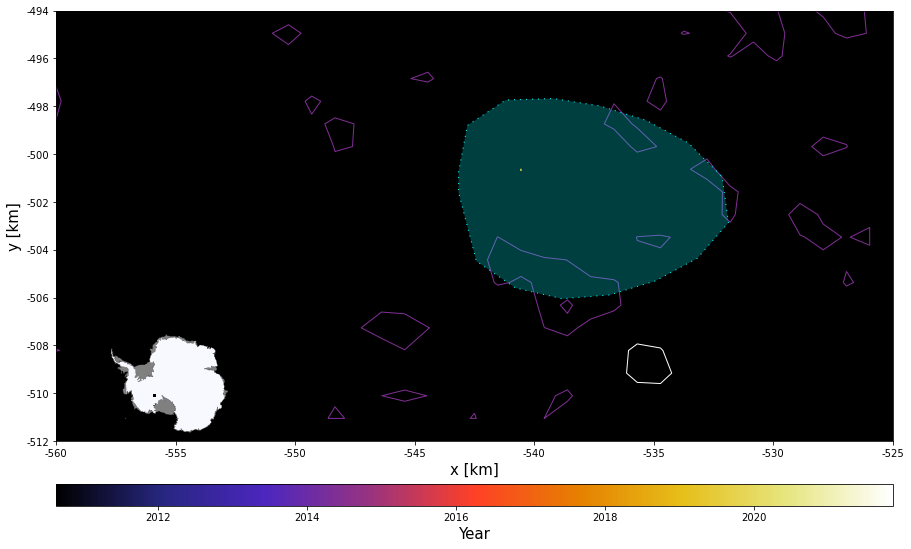

In [164]:
plot_whillans(gdf_non_overlapping)

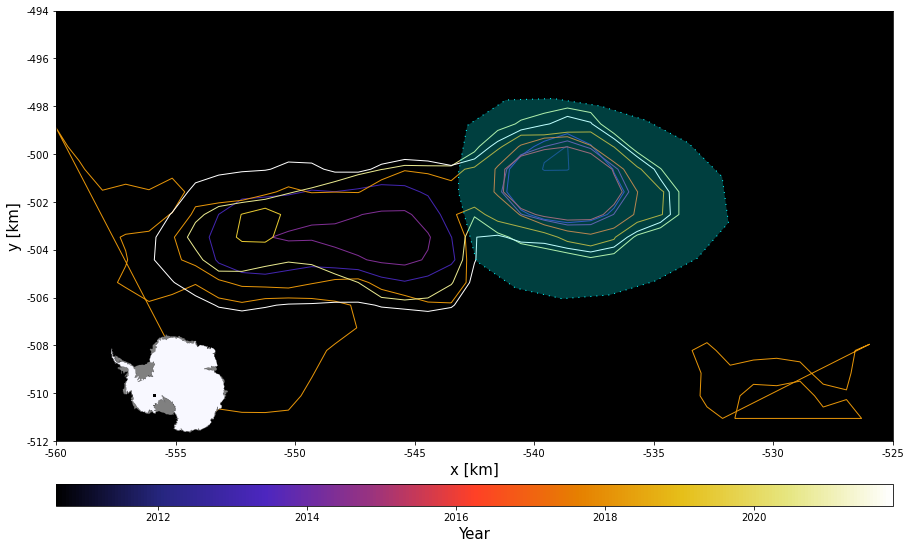

In [165]:
plot_whillans(gdf2_overlapping)

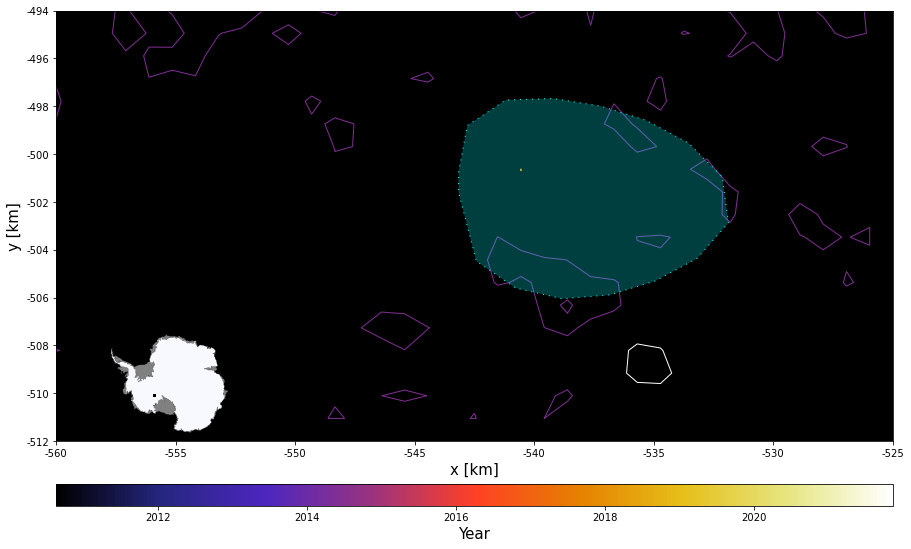

In [167]:
plot_whillans(gdf2_non_overlapping)

In [168]:
gdf2_overlapping

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17
9,"POLYGON ((-553667.673 -511052.632, -553194.444...",38.536168,46.900799,2020-05-17 11:15:00,POINT (-552736.810 -506989.794),2020-05-17


In [169]:
# Find the polygon from geopandas geoDataFrame that has the most extreme centroid x value
gdf2_overlapping.loc[gdf2_overlapping['centroid'].x == gdf2_overlapping['centroid'].x.max()]

,geometry,area (km^2),perim (km),datetime,centroid,date
11,"POLYGON ((-531611.816 -511052.632, -531394.403...",5.703775,12.76901,2020-05-17 11:15:00,POINT (-529352.920 -510450.982),2020-05-17


In [173]:
# Drop the polygon from geopandas geoDataFrame that has the most extreme centroid x value
gdf2_overlapping_remove_outliers = gdf2_overlapping.loc[gdf2_overlapping['centroid'].x != gdf2_overlapping['centroid'].x.max()]
gdf2_overlapping_remove_outliers

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17
9,"POLYGON ((-553667.673 -511052.632, -553194.444...",38.536168,46.900799,2020-05-17 11:15:00,POINT (-552736.810 -506989.794),2020-05-17


In [ ]:
# Drop the polygon from geopandas geoDataFrame that has the most extreme centroid x value
gdf2_overlapping_remove_outliers = gdf2_overlapping_remove_outliers.loc[gdf2_overlapping_remove_outliers['centroid'].x != gdf2_overlapping_remove_outliers['centroid'].x.max()]
gdf2_overlapping_remove_outliers

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17
9,"POLYGON ((-553667.673 -511052.632, -553194.444...",38.536168,46.900799,2020-05-17 11:15:00,POINT (-552736.810 -506989.794),2020-05-17


In [175]:
# Drop the polygon from geopandas geoDataFrame that has the most extreme centroid x value
gdf2_overlapping_remove_outliers = gdf2_overlapping_remove_outliers.loc[gdf2_overlapping_remove_outliers['centroid'].x != gdf2_overlapping_remove_outliers['centroid'].x.min()]
gdf2_overlapping_remove_outliers

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17
12,"POLYGON ((-551250.000 -503683.555, -552222.222...",2.072761,5.493162,2021-05-17 17:15:00,POINT (-551556.096 -503002.046),2021-05-17


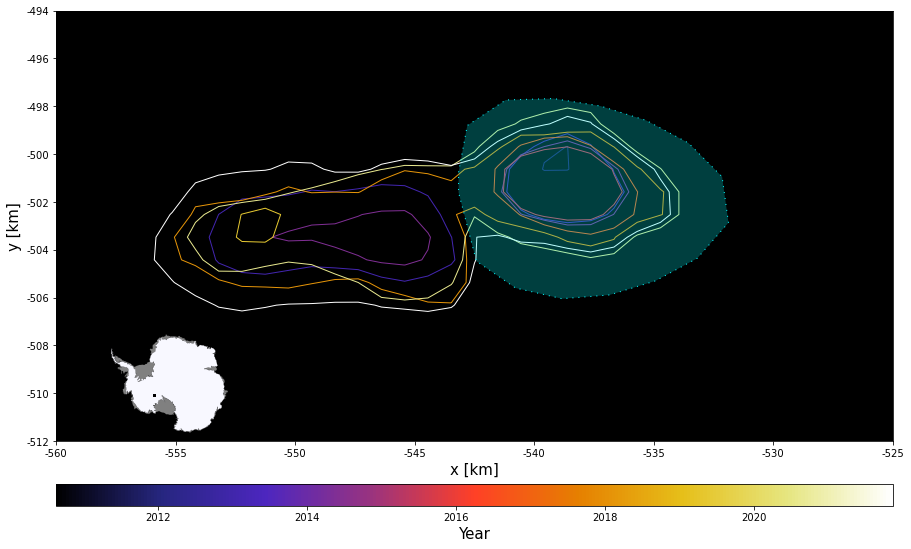

In [176]:
plot_whillans(gdf2_overlapping_remove_outliers)

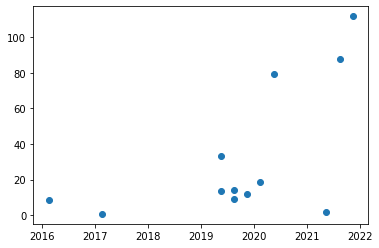

In [182]:
plt.plot(gdf2_overlapping_remove_outliers['date'], gdf2_overlapping_remove_outliers['area (km^2)'], 'o')
plt.show()

In [187]:
len(gdf2_overlapping_remove_outliers)

12

In [274]:
dates_unique = []
areas_evolving = []
for date in gdf2_overlapping_remove_outliers['date'].unique():
    dates_unique.append(date)
    areas_evolving.append(gdf2_overlapping_remove_outliers[gdf2_overlapping_remove_outliers['date'] == date]['area (km^2)'].sum())

print(dates_unique)
print(areas_evolving)

[datetime.date(2016, 2, 15), datetime.date(2017, 2, 15), datetime.date(2019, 5, 18), datetime.date(2019, 8, 17), datetime.date(2019, 11, 16), datetime.date(2020, 2, 16), datetime.date(2020, 5, 17), datetime.date(2021, 5, 17), datetime.date(2021, 8, 17), datetime.date(2021, 11, 16)]
[8.377902470098496, 0.736496914457202, 47.01100854367047, 23.074768312064602, 12.10733058739877, 18.63695366284412, 79.24854888978767, 2.072761138200581, 87.89571328772888, 111.68775153038145]


In [239]:
gdf2_overlapping_remove_outliers

,geometry,area (km^2),perim (km),datetime,centroid,date
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17
12,"POLYGON ((-551250.000 -503683.555, -552222.222...",2.072761,5.493162,2021-05-17 17:15:00,POINT (-551556.096 -503002.046),2021-05-17


In [240]:
gdf2_overlapping_remove_outliers['static area (km^2)'] = np.divide(sum(lake_S09.area), 1e6)

/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [241]:
gdf2_overlapping_remove_outliers

,geometry,area (km^2),perim (km),datetime,centroid,date,static area (km^2)
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15,73.34052
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15,73.34052
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18,73.34052
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18,73.34052
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17,73.34052
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17,73.34052
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16,73.34052
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16,73.34052
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17,73.34052
12,"POLYGON ((-551250.000 -503683.555, -552222.222...",2.072761,5.493162,2021-05-17 17:15:00,POINT (-551556.096 -503002.046),2021-05-17,73.34052


In [242]:
gdf2_overlapping_remove_outliers_copy = gdf2_overlapping_remove_outliers

In [245]:
gdf2_overlapping_remove_outliers_copy = gdf2_overlapping_remove_outliers_copy.rename(columns={"area (km^2)": "evolving area (km^2)"})

In [246]:
gdf2_overlapping_remove_outliers_copy

,geometry,evolving area (km^2),perim (km),datetime,centroid,date,static area (km^2)
0,"POLYGON ((-537019.169 -501578.947, -536666.667...",8.377902,10.546041,2016-02-15 15:45:00,POINT (-538169.880 -500391.484),2016-02-15,73.34052
1,"POLYGON ((-538611.111 -500670.627, -539583.333...",0.736497,3.654067,2017-02-15 15:45:00,POINT (-539002.310 -500310.004),2017-02-15,73.34052
2,"POLYGON ((-537638.889 -502785.067, -538611.111...",13.685261,13.612756,2019-05-18 05:15:00,POINT (-538751.660 -501157.940),2019-05-18,73.34052
3,"POLYGON ((-543472.222 -504614.587, -544444.444...",33.325747,25.121625,2019-05-18 05:15:00,POINT (-548289.287 -503308.228),2019-05-18,73.34052
4,"POLYGON ((-537638.889 -502949.671, -538611.111...",14.239809,14.073668,2019-08-17 12:45:00,POINT (-538726.578 -501294.464),2019-08-17,73.34052
5,"POLYGON ((-545416.667 -504640.147, -546388.889...",8.834959,15.126013,2019-08-17 12:45:00,POINT (-546797.667 -503465.185),2019-08-17,73.34052
6,"POLYGON ((-537638.889 -502738.778, -538611.111...",12.107331,13.086339,2019-11-16 20:15:00,POINT (-538838.795 -501268.778),2019-11-16,73.34052
7,"POLYGON ((-536666.667 -503093.459, -537638.889...",18.636954,16.164394,2020-02-16 03:45:00,POINT (-538673.400 -501336.178),2020-02-16,73.34052
8,"POLYGON ((-543472.222 -506222.071, -544444.444...",79.248549,51.223367,2020-05-17 11:15:00,POINT (-544719.757 -502726.290),2020-05-17,73.34052
12,"POLYGON ((-551250.000 -503683.555, -552222.222...",2.072761,5.493162,2021-05-17 17:15:00,POINT (-551556.096 -503002.046),2021-05-17,73.34052


In [273]:
gdf2_overlapping_remove_outliers_copy.to_csv('area_time_series_{}.csv'.format(lake_S09['Name'].values[0]), columns=['date', 'static area (km^2)', 'evolving area (km^2)'])

In [ ]:
lake_S09 = Smith2009_outlines[(Smith2009_outlines['Name'] == 'Whillans_7')]
S09_color = 'lightseagreen'

fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(15,5))

# Plot 0 - plot evolving outlines
# Set up dataset
dataset1 = CS2_dh
dataset2 = ATL15_dh

# Find mid-cycle dates of combined CS2 and IS2 data
dates = []
for idx in range(len(dataset1.delta_h[:-12])):
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
        newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
for idx in range(len(dataset2.delta_h)-1): 
    if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
        date_time_str = '18-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
        newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
        midcycdays = newdate1 - newdate
        midcycdate = newdate + midcycdays/2
        dates += [midcycdate]

region_or_lake = 'Whillans_7'
buffer = 15000

# Isolate individual lake using gpd buffer
lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
lake_buffer = lake_gpd.buffer(buffer)
# Define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

# manually set because of lake-adjacent lobe
x_min = -560e3; x_max = -525e3
y_min = -512e3; y_max = -494e3

cmap = plt.get_cmap('autumn')
# norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])

m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="5%", pad=0.6)
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=15)

# Add black background to see all outlines
rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
axs[0].add_artist(rect) 

# Create lines for legend
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=2)
# SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
# evolving_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
# uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
# subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

# Create legend
axs[0].legend([Smith2009, 
    # SiegfriedFricker2018, 
    # evolving_outlines
    ],
    ['Smith and others, 2009 static outline',
    # 'Siegfried & Fricker, 2018 static outline',
    # 'evolving outline',
    # ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'
    ], 
    loc='upper left')

gdf2_overlapping_remove_outliers.plot(ax=axs[0], 
    column='date',
    facecolor='none',
    cmap=cmap,
    legend=True
    )

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
axs[0].yaxis.set_major_formatter(ticks_y)
axs[0].set_aspect('equal')

# Label axes and set limits
axs[0].set_xlabel('x [km]', size=15)
axs[0].set_ylabel('y [km]', size=15)
axs[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=axs[0], facecolor=S09_color, linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=axs[0], edgecolor=S09_color, linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=axs[0], edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=axs[0], edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
moa_2014_groundingline.boundary.plot(ax=axs[0], edgecolor='k', linewidth=1)

# Plot inset map to show location 
axIns = axs[0].inset_axes([-0.05, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=4, color='k', zorder=4)
# axIns.add_artist(rect)
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
axIns.axis('off')

# Plot 1 - plot area change time series
axs[1].axhline(np.divide(sum(lake_S09.area), 1e6), color=S09_color, linestyle=(0, (1, 4)))
axs[1].plot(dates_unique, areas_evolving, color='k', linestyle=(0, (1, 1)))
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)
min_area = min(np.divide(sum(lake_S09.area), 1e6), 
                # np.divide(sum(lake_SF18.area), 1e6), 
                min(areas_evolving))
max_area = max(np.divide(sum(lake_S09.area), 1e6), 
                # np.divide(sum(lake_SF18.area), 1e6), 
                max(areas_evolving))
axs[1].set(ylim=((min_area - (max_area - min_area)*0.05), (max_area + (max_area - min_area)*0.05)),
    xlim=(dates[0], dates[-1]))
axs[1].set_ylabel('lake area [km$^2$]', size=17.5, labelpad=4)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 4)), linewidth=3)
evolving_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=3)
legend2 = axs[1].legend([Smith2009,
    #SiegfriedFricker2018,
    evolving_outlines],
                ['static outline',
    #'Siegfried & Fricker, 2018 static outline',
    # '±{} m variable outlines'.format(thres)], 
    'evolving outlines'],
    loc='upper right')
legend2.get_frame().set_linewidth(0.0)
axs[1].patch.set_alpha(1)

In [409]:
def plot_variable_outlines(gdf, region_or_lake, buffer, threshold):
    # Set up dataset
    dataset1 = CS2_dh
    dataset2 = ATL15_dh
    dates = []
    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
    lake_buffer = lake_gpd.buffer(buffer)
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

    # create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    cmap = plt.get_cmap('plasma', len(dates)-1)
    # norm = plt.Normalize(dates[0], dates[-1])
    norm = plt.Normalize(datetime2fracyear(dates[0]), datetime2fracyear(dates[-1]))

    print(norm)

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('Year', size=15)

    # Add black background to see all outlines
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    for idx, dt in enumerate(dates[0:-1], 0):
        gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
            color=cmap(norm(datetime2fracyear(dates[idx])))
            )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 5)), linewidth=2)
    # SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
    evolving_outlines = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
    # uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    # subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Create legend
    axs[0].legend([Smith2009, 
    # SiegfriedFricker2018, 
    # evolving_outlines
    ],
    ['Smith and others, 2009 static outline',
    # 'Siegfried & Fricker, 2018 static outline',
    'evolving outline',
    # ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'
    ], 
    loc='upper left')

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/figX_subglacial_lake_areas/variable_outlines_{}_{}km_{}m.png'.format(region_or_lake, buffer/1e3, threshold), dpi=300, bbox_inches='tight')

In [464]:
def plot_variable_outlines(gdf, region_or_lake, buffer, threshold):
    # Set up dataset
    dataset1 = CS2_dh
    dataset2 = ATL15_dh
    dates = []
    # Find mid-cycle dates of combined CS2 and IS2 data
    dates = []
    for idx in range(len(dataset1.delta_h[:-12])):
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
    for idx in range(len(dataset2.delta_h)-1): 
        if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]

    # Isolate individual lake using gpd buffer
    lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == region_or_lake]  
    lake_buffer = lake_gpd.buffer(buffer)
    # Define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

    # create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    cmap = plt.get_cmap('plasma', len(dates)-1)
    # norm = plt.Normalize(dates[0], dates[-1])
    norm = plt.Normalize(datetime2fracyear(dates[0]), datetime2fracyear(dates[-1]))

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see all outlines
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(dates[idx]))), linewidth=3)
        lines.append(line)
        gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
            color=cmap(norm(datetime2fracyear(dates[idx])))
            )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    # uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    # subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 outline', 
            'evolving outline ({} m threshold)'.format(threshold)], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')

    plt.savefig(OUTPUT_DIR + '/figX_subglacial_lake_areas/variable_outlines_{}_{}km_{}m.png'.format(region_or_lake, buffer/1e3, threshold), dpi=300, bbox_inches='tight')

    # plt.close()

In [ ]:
plot_variable_outlines(gdf, 'Whillans_7', 20000, 0.5)

/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


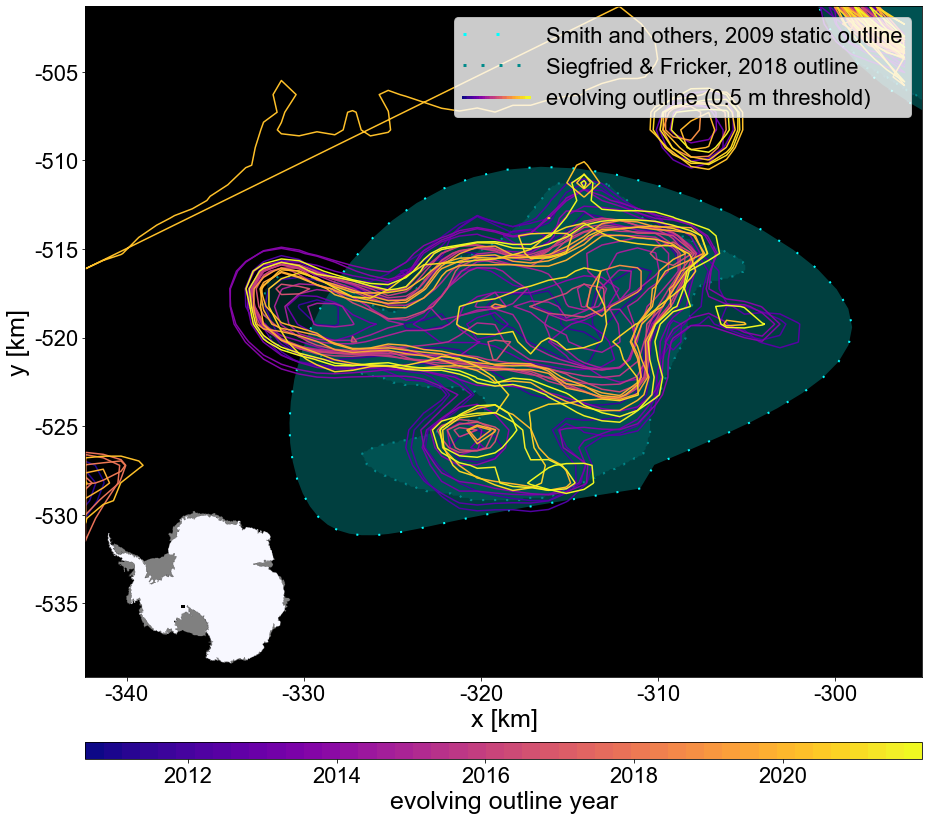

In [465]:
lakename = 'ConwaySubglacialLake'
buffer = 10000
threshold = 0.5
gdf = S09SF18S23_outline_timeseries_gdf(lakename, buffer, threshold, CS2_dh, ATL15_dh)

overlapping = []
non_overlapping = []
for n, p in enumerate(list(gdf.geometry), 0):
    if any(p.overlaps(g) for g in list(gdf.geometry)):
        # Store the index from the original dataframe
        overlapping.append(n)
    if not any(p.overlaps(g) for g in list(gdf.geometry)):
        non_overlapping.append(n)

# Create a new dataframes and reset their indexes
gdf_overlapping = gdf.iloc[overlapping]  
gdf_overlapping.reset_index(drop=True, inplace=True)
gdf_non_overlapping = gdf.iloc[non_overlapping]
gdf_non_overlapping.reset_index(drop=True, inplace=True)

plot_variable_outlines(gdf_overlapping, lakename, buffer, threshold)

In [ ]:
for idx in range(len(Sauthoff2023_outlines)):
    lakename = Sauthoff2023_outlines['name'][idx]
    buffer = 15000
    threshold = 0.5
    gdf = S09SF18S23_outline_timeseries_gdf(lakename, buffer, threshold, CS2_dh, ATL15_dh)
    plot_variable_outlines(gdf, lakename, buffer, threshold)